# Classify Genres and Emotions in Songs Using Deep Learning

## Description:

The goal of this lab is to recognize the genre and extract the emotions from spectrograms of music songs. We are given 2 datasets:
- Free Music Archive (FMA) genre that contains 3834 samples from 20 music genres.
- Multitask music dataset that contains 1497 samples with labels about the emotions such as valence, energy and danceability.

All samples came from spectrograms, that have been extracted from clips of 30 seconds from different songs.

We will analyze the spectrograms using deep learning architectures such as Recurrent Neural Networks and Convolutional Neural Networks. The exercise is separated in 5 parts:

1. Data analysis and familiarize with spectrograms.
2. Implement classifiers about the music genre using the FMA dataset.
3. Implement regression models for predicting valence, energy and danceability.
4. Use of modern training techniques, such as transfer and multitask learning, to improve the previous results.
5. Submit results in the Kaggle competition of the exercise.

## Implementation

In the prepare lab, we will classify music genres using the spectrograms.

In [1]:
# Import necessary libraries
import numpy as np
import copy
import re
import os
import pandas as pd
import random
import librosa.display
import matplotlib.pyplot as plt
# sklearn
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
# Pytorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader

### Step 0: Familiarize with kaggle kernels
Open a private kernel in kaggle and load the data. Run the command **os.listdir("../input/patreco3-multitask-affective-music/data/")** to check the subfolders of the dataset. Try enabling and disabling the GPU and commit your changes.

In [2]:
os.listdir("../input/patreco3-multitask-affective-music/data/")

['multitask_dataset_beat',
 'multitask_dataset',
 'fma_genre_spectrograms_beat',
 'fma_genre_spectrograms']

## Step 1: Familiarize with spectrograms in mel scale

1. Choose two files randomly

In [3]:
fixed = True

if not fixed:
    # Open train_labels.txt file and choose two random lines (with different labels).
    with open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt', 'r') as f:
        lines = f.readlines()
        # The first element is the headers.
        train_size = len(lines) - 1
        idx_1 = random.randint(1,train_size)
        filename_1, label_1 = lines[idx_1].split()

        label_2 = label_1
        while (label_2 == label_1):
            idx_2 = random.randint(1,train_size)
            filename_2, label_2 = lines[idx_2].split()
else:
    filename_1 = '63227.fused.full.npy.gz'
    label_1 = 'Blues'
    filename_2 = '28466.fused.full.npy.gz'
    label_2 = 'Jazz'
    
    
print('1st file: %s %s' %(filename_1, label_1))
print('2nd file: %s %s' %(filename_2, label_2))

1st file: 63227.fused.full.npy.gz Blues
2nd file: 28466.fused.full.npy.gz Jazz


- Load the spectograms and keep the mel-spectograms.

In [4]:
spec_1 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + filename_1.strip(".gz"))
spec_2 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' + filename_2.strip(".gz"))

print('Shape of 1st spectrogram:')
print(spec_1.shape)
print('Shape of 2nd spectrogram:') 
print(spec_2.shape)

mel_1 = spec_1[:128]
mel_2 = spec_2[:128]

Shape of 1st spectrogram:
(140, 1291)
Shape of 2nd spectrogram:
(140, 1291)


- Plot the spectrograms.

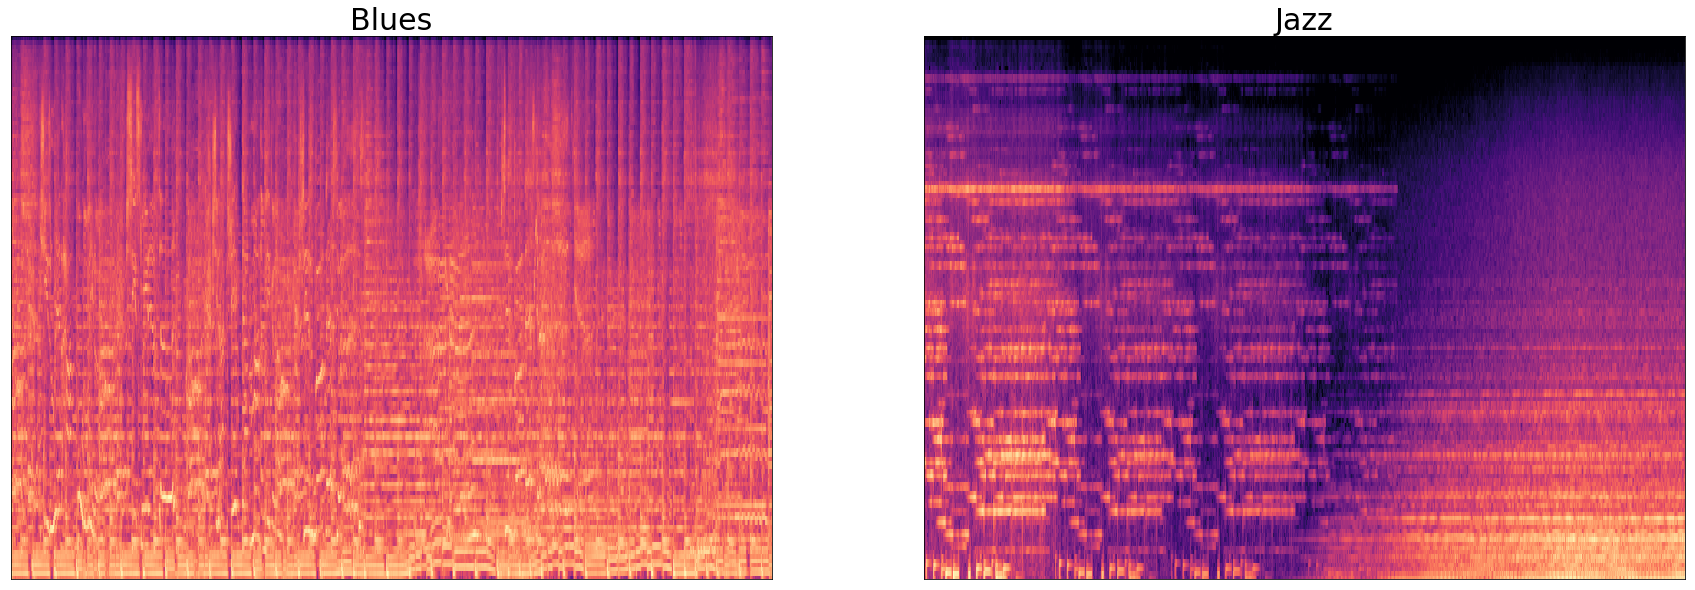

In [5]:
plt.rcParams['figure.figsize'] = [30, 10]

plt.subplot(1, 2, 1)
plt.title(label_1, fontsize=30)
librosa.display.specshow(mel_1)
plt.subplot(1, 2, 2)
plt.title(label_2, fontsize=30)
librosa.display.specshow(mel_2)

In the above spectrograms, the horizontal axis represents time, and the vertical axis represents frequency. A third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity of color of each point in the image. If we compare the above spectrograms, we can see that the Blues music has lower frequencies the entire time, while the Jazz music has many changes in the frequency over time. More generally, songs from the same genre will have similar frequency changes over time.

## Step 2: beat-synced spectrograms

- Print the shape of the mel-spectrograms.

In [6]:
print('Shape of 1st mel-spectrogram:')
print(mel_1.shape)
print('Shape of 2nd mel-spectrogram:') 
print(mel_2.shape)

Shape of 1st mel-spectrogram:
(128, 1291)
Shape of 2nd mel-spectrogram:
(128, 1291)


We can see that the timesteps of the mel-spectrograms are 1291 and 1291 respectively. If we trained our LSTM in these data, our model will not be efficient enough, since the length of each sample will be very large. In order to resolve this problem, we should synchronize the spectrogram with the beat of the music. This is done by taking the median between the points of the beat. The final files are placed in '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/'.

In [7]:
spec_1_beat = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + filename_1.strip(".gz"))
spec_2_beat = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' + filename_2.strip(".gz"))

mel_1_beat = spec_1_beat[:128]
mel_2_beat = spec_2_beat[:128]

print('Shape of 1st mel-spectrogram after beat-sync:')
print(mel_1_beat.shape)
print('Shape of 2nd mel-spectrogram after beat-sync:') 
print(mel_2_beat.shape)

Shape of 1st mel-spectrogram after beat-sync:
(128, 69)
Shape of 2nd mel-spectrogram after beat-sync:
(128, 36)


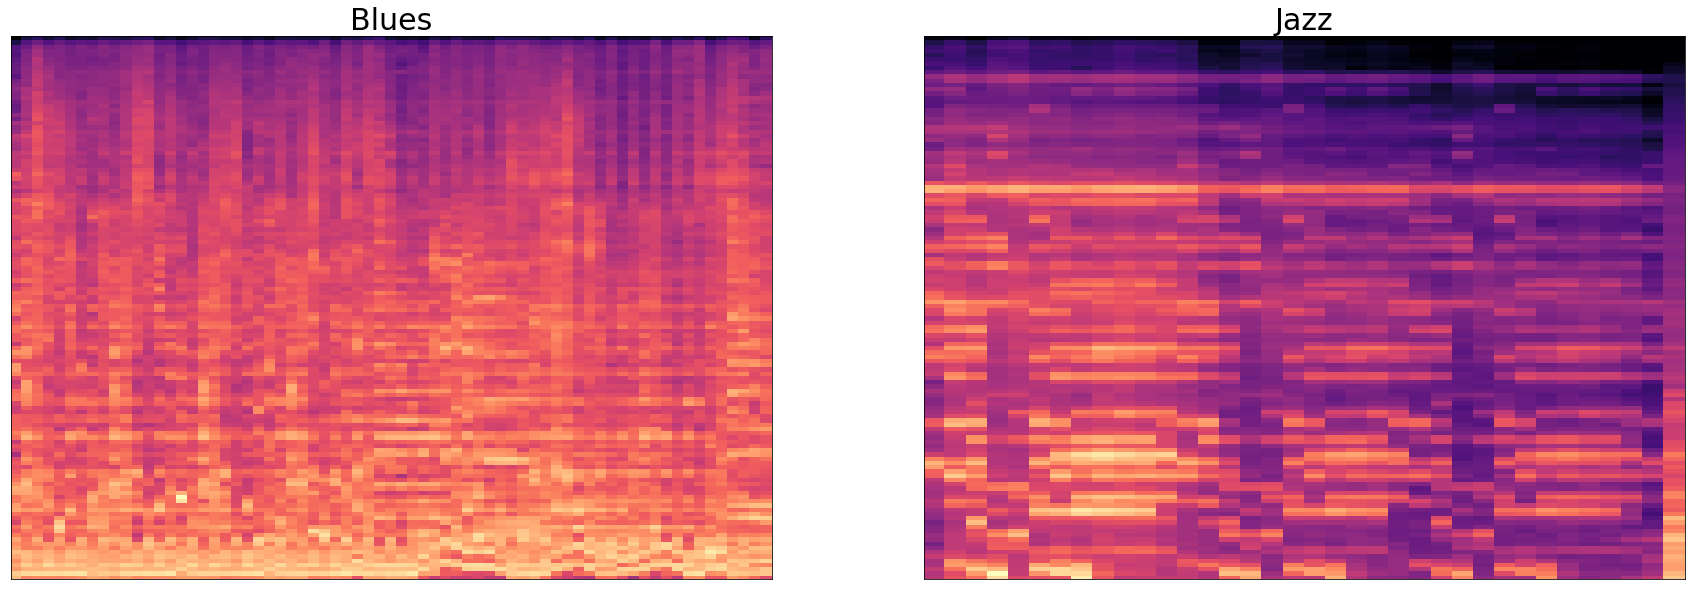

In [8]:
plt.subplot(1, 2, 1)
plt.title(label_1, fontsize=30)
librosa.display.specshow(mel_1_beat)
plt.subplot(1, 2, 2)
plt.title(label_2, fontsize=30)
librosa.display.specshow(mel_2_beat)

We observe that the changes in the frequency are almost the same, despite the fact that the timesteps are less.

## Step 3: Familiarize with chromagrams

In [9]:
chroma_1 = spec_1[128:]
chroma_2 = spec_2[128:]

print('Shape of 1st chromagram:')
print(chroma_1.shape)
print('Shape of 2nd chromagram:') 
print(chroma_2.shape)

chroma_1_beat = spec_1_beat[128:]
chroma_2_beat = spec_2_beat[128:]

print('Shape of 1st chromagram after beat-sync:')
print(chroma_1_beat.shape)
print('Shape of 2nd chromagram after beat-sync:') 
print(chroma_2_beat.shape)

Shape of 1st chromagram:
(12, 1291)
Shape of 2nd chromagram:
(12, 1291)
Shape of 1st chromagram after beat-sync:
(12, 69)
Shape of 2nd chromagram after beat-sync:
(12, 36)


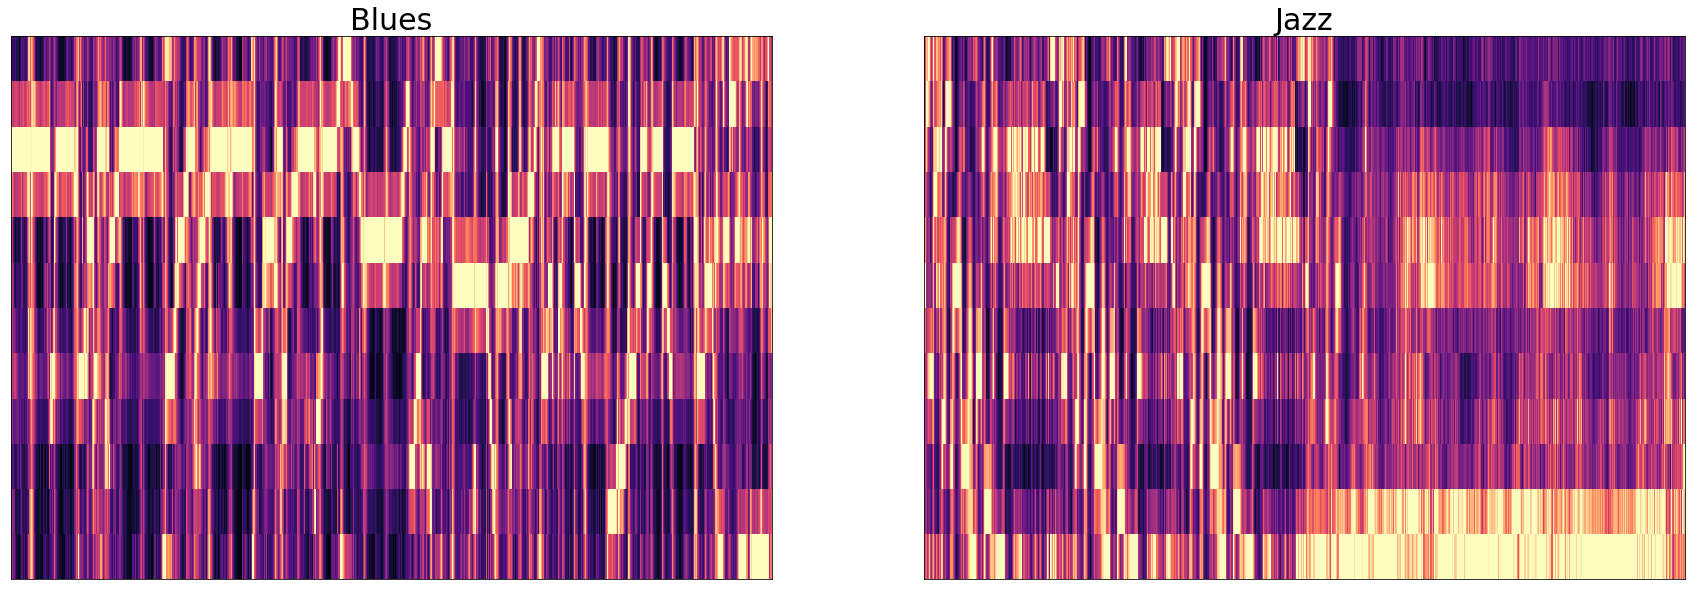

In [10]:
plt.subplot(1, 2, 1)
plt.title(label_1, fontsize=30)
librosa.display.specshow(chroma_1)
plt.subplot(1, 2, 2)
plt.title(label_2, fontsize=30)
librosa.display.specshow(chroma_2)

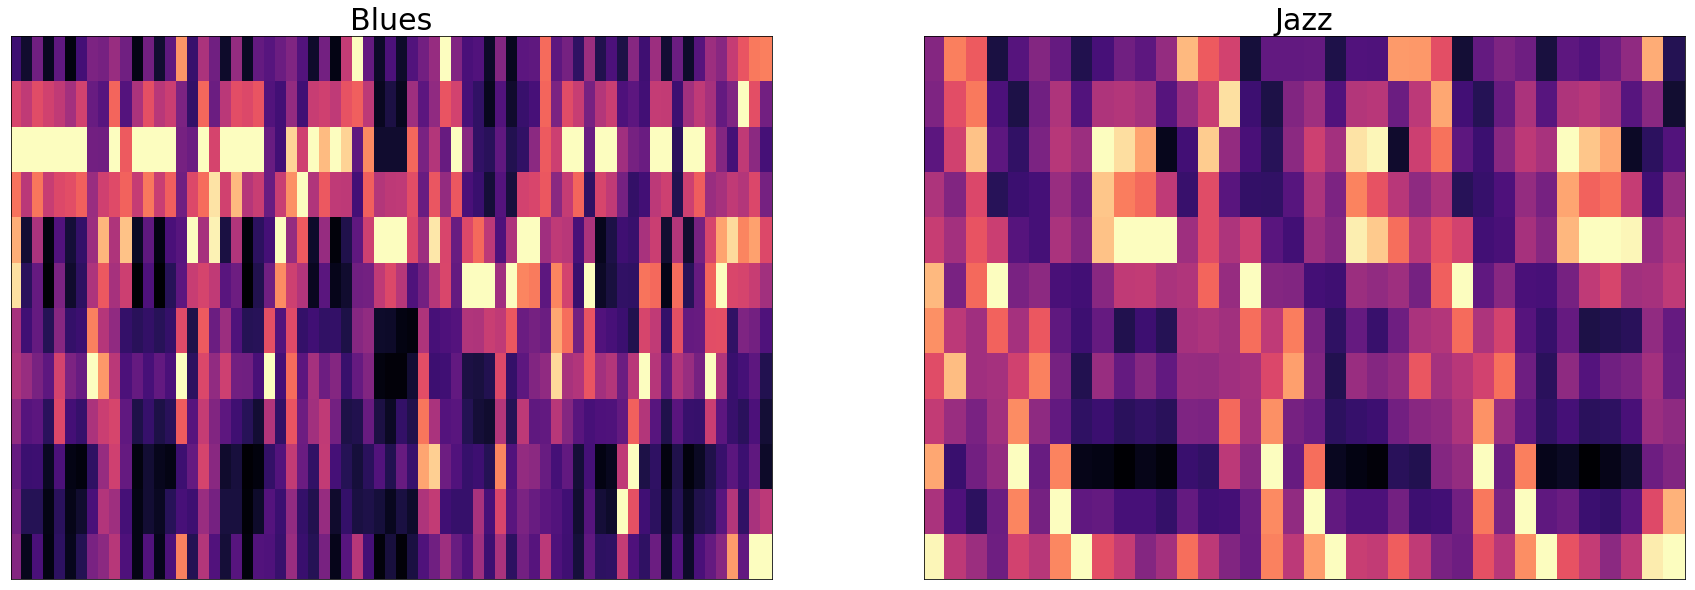

In [11]:
plt.subplot(1, 2, 1)
plt.title(label_1, fontsize=30)
librosa.display.specshow(chroma_1_beat)
plt.subplot(1, 2, 2)
plt.title(label_2, fontsize=30)
librosa.display.specshow(chroma_2_beat)

## Step 4: Load and Analyze data

- Combine similar classes and remove underrepresented classes. Similar classes are combined because our classifier will find it difficult to distinguish them. On the other hand, classes that are underrepresented will not be correctly recognized because their available training data will not be enough.

In [12]:
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

- Split dataset in train and validation set.

In [13]:
def torch_train_val_split(dataset, batch_train, batch_eval, val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    # Rearrange train and validation set
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader

- Define some useful functions for loading spectrograms and chromagrams

In [14]:
def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T

- Define an encoder for the labels.

In [15]:
class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])

- Define a PaddingTransformer in order to convert all input sequences to the same length.

In [16]:
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

- Define Pytorch dataset

In [17]:
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    

    def __getitem__(self, item):
        # Return a tuple in the form (padded_feats, label, length)
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)


- Load mel spectrograms

In [18]:
mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
test_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_mel, batch_size=32)

- Load beat synced mel spectrograms

In [19]:
beat_mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
test_beat_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_beat_mel = DataLoader(test_beat_mel, batch_size=32)

- Load beat synced chromagrams

In [20]:
beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32 ,32, val_size=.33)
test_beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
test_loader_beat_chroma = DataLoader(test_beat_chroma, batch_size=32)

- Load fused speectrogram + chromagram for the full (non-beat-synced) data

In [21]:
specs_fused = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)
test = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
test_loader = DataLoader(test, batch_size=32)

- Display 2 histograms, one before class_mapping and one after.

In [22]:
# Load the beat sync mel-spectrograms without class mapping.
beat_mel_specs_nomap = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)

In [23]:
# Keep all the train labels before the mapping.

labels_before = []
for i in range(len(beat_mel_specs_nomap)):
    _, label, _ = beat_mel_specs_nomap[i]
    labels_before.append(label)

In [24]:
# Keep all the train labels after the mapping.

labels_after = []
for i in range(len(beat_mel_specs)):
    _, label, _ = beat_mel_specs[i]
    labels_after.append(label)

Text(0.5, 1.0, 'After class mapping')

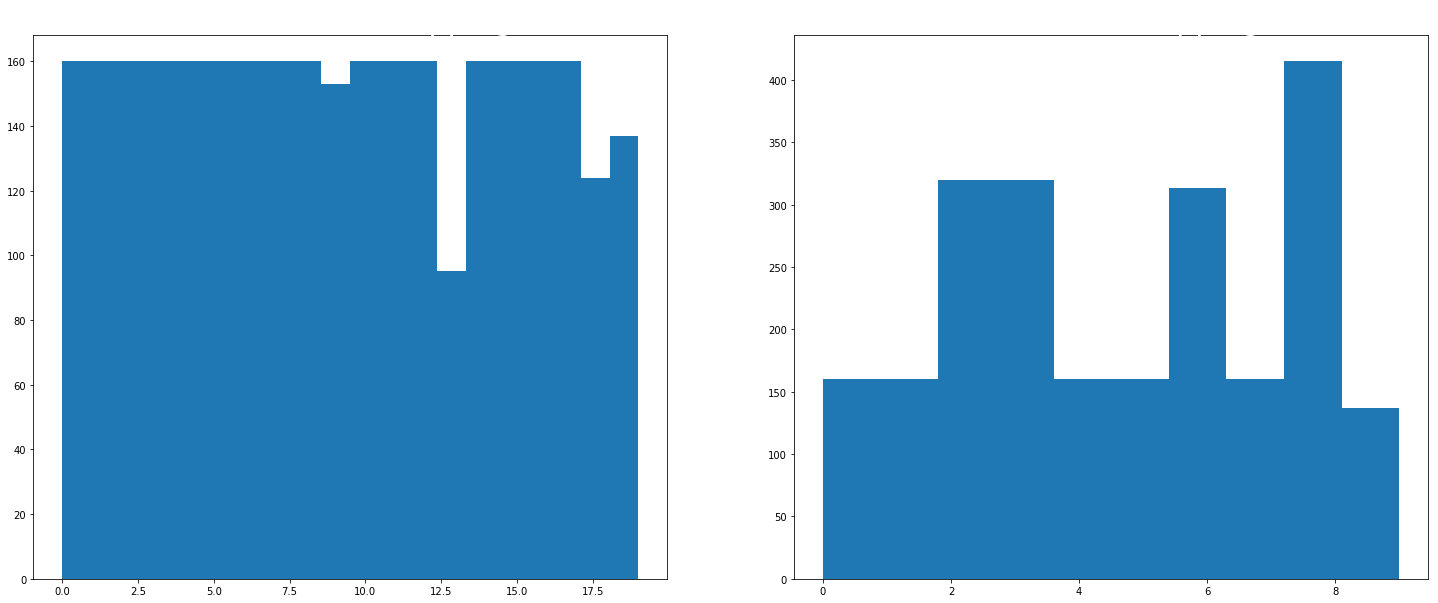

In [25]:
# Plot the histograms side by side.

plt.rcParams['figure.figsize'] = [25, 10]
plt.subplot(1, 2, 1)
plt.title('Before class mapping', color='w', fontsize=30)
plt.hist(labels_before, bins=20)
plt.subplot(1, 2, 2)
plt.hist(labels_after, bins=10)
plt.title('After class mapping', color='w', fontsize=30)

## Step 5: Music Genre Classification using LSTM

- Define LSTM

In [26]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).double().to(DEVICE)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).double().to(DEVICE)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).double().to(DEVICE)
            c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).double().to(DEVICE)
            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1).to(DEVICE)
        return outputs.gather(1, idx).squeeze()

- Define a function that trains the model for an epoch.

In [27]:
def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    # IMPORTANT: switch to train mode
    # Εnable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0

    # Οbtain the model's device ID
    device = next(model.parameters()).device
    
    for index, batch in enumerate(dataloader, 1):
        # Get the inputs (batch)
        inputs, labels, lengths = batch

        # Move the batch tensors to the right device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Step 1 - zero the gradients
        # Remember that PyTorch accumulates gradients.
        # We need to clear them out before each batch!
        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        y_preds = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(y_preds, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        # Accumulate loss in a variable.
        running_loss += loss.data.item()

    return running_loss / index

- Define a function that evaluates the model in an epoch.

In [28]:
def eval_dataset(dataloader, model, loss_function):
    # IMPORTANT: switch to eval mode
    # Disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # Obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()

    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):
            # Get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Step 2 - forward pass: y' = model(x)
            y_preds = model(inputs, lengths)  # EX9

            # Step 3 - compute loss: L = loss_function(y, y')
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(y_preds, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            y_preds_arg = torch.argmax(y_preds, dim=1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.append(y_preds_arg.cpu().numpy())
            y.append(labels.cpu().numpy())

            # Accumulate loss in a variable
            running_loss += loss.data.item()

    return running_loss / index, (y, y_pred)

### Test the model by training only in one batch to make it to overfit.

For convenience, we save the models and each time we want to analyze them we load them back.

In [29]:
# Define useful parameters that are the same for all the models.
num_mel = 128
num_chroma = 12
n_classes = 10

In [30]:
train_batch = next(iter(train_loader_beat_mel))

RNN_SIZE = 32
EPOCHS = 5000

model = BasicLSTM(num_mel, RNN_SIZE, n_classes, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    # IMPORTANT: switch to train mode
    # Εnable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0

    # Οbtain the model's device ID
    device = next(model.parameters()).device

    # Get the inputs (batch)
    inputs, labels, lengths = train_batch
    

    # Move the batch tensors to the right device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Step 1 - zero the gradients
    # Remember that PyTorch accumulates gradients.
    # We need to clear them out before each batch!
    optimizer.zero_grad()

    # Step 2 - forward pass: y' = model(x)
    y_preds = model(inputs, lengths)

    # Step 3 - compute loss: L = loss_function(y, y')
    loss = loss_function(y_preds, labels)

    # Step 4 - backward pass: compute gradient wrt model parameters
    loss.backward()

    # Step 5 - update weights
    optimizer.step()

    # Accumulate loss in a variable.
    running_loss = loss.data.item()
    
    if epoch%100 == 0:
        print("Epoch %d with loss: %f" %(epoch, running_loss))

torch.save(model, './overtrained_model')

Epoch 0 with loss: 2.358230
Epoch 100 with loss: 1.336089
Epoch 200 with loss: 0.710659
Epoch 300 with loss: 0.377532
Epoch 400 with loss: 0.225703
Epoch 500 with loss: 0.150722
Epoch 600 with loss: 0.110425
Epoch 700 with loss: 0.082314
Epoch 800 with loss: 0.064502
Epoch 900 with loss: 0.051744
Epoch 1000 with loss: 0.042513
Epoch 1100 with loss: 0.036044
Epoch 1200 with loss: 0.030990
Epoch 1300 with loss: 0.026932
Epoch 1400 with loss: 0.023448
Epoch 1500 with loss: 0.020718
Epoch 1600 with loss: 0.018266
Epoch 1700 with loss: 0.016261
Epoch 1800 with loss: 0.014284
Epoch 1900 with loss: 0.012732
Epoch 2000 with loss: 0.011458
Epoch 2100 with loss: 0.010377
Epoch 2200 with loss: 0.009418
Epoch 2300 with loss: 0.008599
Epoch 2400 with loss: 0.007883
Epoch 2500 with loss: 0.007247
Epoch 2600 with loss: 0.006556
Epoch 2700 with loss: 0.005475
Epoch 2800 with loss: 0.004879
Epoch 2900 with loss: 0.004481
Epoch 3000 with loss: 0.004139
Epoch 3100 with loss: 0.003837
Epoch 3200 with loss

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Train the model in the mel spectrograms

In [31]:
RNN_SIZE = 32
EPOCHS = 500

model = BasicLSTM(num_mel, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader_mel, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader_mel, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader_mel, model, loss_function)
    
    if epoch%(100) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()
        
torch.save(model, './mel_32_500')

Epoch 0 
Train loss: 2.219316
Validation loss: 2.226722
Accuracy for train: 0.16310679611650486
Accuracy for validation: 0.15526315789473685

Epoch 100 
Train loss: 2.206539
Validation loss: 2.231472
Accuracy for train: 0.18705501618122977
Accuracy for validation: 0.1723684210526316

Epoch 200 
Train loss: 2.203029
Validation loss: 2.228832
Accuracy for train: 0.18640776699029127
Accuracy for validation: 0.1723684210526316

Epoch 300 
Train loss: 2.205863
Validation loss: 2.235733
Accuracy for train: 0.18640776699029127
Accuracy for validation: 0.1723684210526316

Epoch 400 
Train loss: 2.201068
Validation loss: 2.234022
Accuracy for train: 0.18640776699029127
Accuracy for validation: 0.1723684210526316



In [32]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader_mel, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.23      0.12      0.16        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.19      0.97      0.32       103
           9       0.00      0.00      0.00        34

    accuracy                           0.19       575
   macro avg       0.04      0.11      0.05       575
weighted avg       0.07      0.19      0.08       575



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Train the model in the beat synced mel spectrograms

In [33]:
RNN_SIZE = 32
EPOCHS = 500

model = BasicLSTM(num_mel, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader_beat_mel, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader_beat_mel, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader_beat_mel, model, loss_function)
    
    if epoch%(100) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()
        
torch.save(model, './beat_mel_32_500')

Epoch 0 
Train loss: 2.205512
Validation loss: 2.202397
Accuracy for train: 0.18122977346278318
Accuracy for validation: 0.17763157894736842

Epoch 100 
Train loss: 1.930599
Validation loss: 1.957292
Accuracy for train: 0.3048543689320388
Accuracy for validation: 0.2881578947368421

Epoch 200 
Train loss: 1.858046
Validation loss: 1.911782
Accuracy for train: 0.32168284789644014
Accuracy for validation: 0.3105263157894737

Epoch 300 
Train loss: 1.836616
Validation loss: 1.923526
Accuracy for train: 0.32427184466019415
Accuracy for validation: 0.31973684210526315

Epoch 400 
Train loss: 1.814975
Validation loss: 1.923402
Accuracy for train: 0.3365695792880259
Accuracy for validation: 0.3236842105263158



In [34]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader_beat_mel, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.34      0.40      0.37        40
           2       0.27      0.64      0.38        80
           3       0.29      0.35      0.31        80
           4       0.00      0.00      0.00        40
           5       0.15      0.05      0.08        40
           6       0.35      0.37      0.36        78
           7       0.00      0.00      0.00        40
           8       0.31      0.44      0.36       103
           9       0.00      0.00      0.00        34

    accuracy                           0.30       575
   macro avg       0.17      0.22      0.19       575
weighted avg       0.21      0.30      0.24       575



As we can see, all the metrics are higher due to the beat synchronization.

In [35]:
RNN_SIZE = 64
EPOCHS = 1000

model = BasicLSTM(num_mel, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-5)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader_beat_mel, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader_beat_mel, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader_beat_mel, model, loss_function)
    
    if epoch%(100) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()

torch.save(model, './beat_mel_32_1000')

Epoch 0 
Train loss: 2.215889
Validation loss: 2.212827
Accuracy for train: 0.18122977346278318
Accuracy for validation: 0.17763157894736842

Epoch 100 
Train loss: 2.114815
Validation loss: 2.093770
Accuracy for train: 0.23559870550161813
Accuracy for validation: 0.24473684210526317

Epoch 200 
Train loss: 2.153186
Validation loss: 2.111320
Accuracy for train: 0.21941747572815534
Accuracy for validation: 0.23421052631578948

Epoch 300 
Train loss: 2.060212
Validation loss: 2.132161
Accuracy for train: 0.2543689320388349
Accuracy for validation: 0.24868421052631579

Epoch 400 
Train loss: 2.046508
Validation loss: 2.115681
Accuracy for train: 0.2608414239482201
Accuracy for validation: 0.24868421052631579

Epoch 500 
Train loss: 2.092422
Validation loss: 2.097823
Accuracy for train: 0.24660194174757283
Accuracy for validation: 0.25263157894736843

Epoch 600 
Train loss: 2.046419
Validation loss: 2.128136
Accuracy for train: 0.2614886731391586
Accuracy for validation: 0.2460526315789473

In [36]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader_beat_mel, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.22      0.88      0.35        80
           3       0.25      0.05      0.08        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.30      0.70      0.42       103
           9       0.00      0.00      0.00        34

    accuracy                           0.25       575
   macro avg       0.08      0.16      0.09       575
weighted avg       0.12      0.25      0.14       575



### Train the model in the beat synced chromagrams

In [37]:
RNN_SIZE = 16
EPOCHS = 300

model = BasicLSTM(num_chroma, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader_beat_chroma, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader_beat_chroma, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader_beat_chroma, model, loss_function)
    
    if epoch%(50) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()

torch.save(model, './beat_chroma_16_300')

Epoch 0 
Train loss: 2.223102
Validation loss: 2.229959
Accuracy for train: 0.17605177993527507
Accuracy for validation: 0.19473684210526315

Epoch 50 
Train loss: 2.042511
Validation loss: 2.132372
Accuracy for train: 0.2537216828478964
Accuracy for validation: 0.20394736842105263

Epoch 100 
Train loss: 1.921056
Validation loss: 2.207336
Accuracy for train: 0.2977346278317152
Accuracy for validation: 0.20657894736842106

Epoch 150 
Train loss: 1.822410
Validation loss: 2.256016
Accuracy for train: 0.3268608414239482
Accuracy for validation: 0.22631578947368422

Epoch 200 
Train loss: 1.734896
Validation loss: 2.339124
Accuracy for train: 0.37346278317152104
Accuracy for validation: 0.2

Epoch 250 
Train loss: 1.545418
Validation loss: 2.451627
Accuracy for train: 0.458252427184466
Accuracy for validation: 0.21052631578947367



In [38]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader_beat_chroma, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.14      0.05      0.07        40
           1       0.11      0.07      0.09        40
           2       0.23      0.40      0.29        80
           3       0.21      0.34      0.26        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.24      0.22      0.23        78
           7       0.00      0.00      0.00        40
           8       0.20      0.33      0.25       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.11      0.14      0.12       575
weighted avg       0.15      0.20      0.16       575



In [39]:
RNN_SIZE = 32
EPOCHS = 500

model = BasicLSTM(num_chroma, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader_beat_chroma, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader_beat_chroma, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader_beat_chroma, model, loss_function)
    
    if epoch%(50) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()

torch.save(model, './beat_chroma_32_500_l2reg')

Epoch 0 
Train loss: 2.212070
Validation loss: 2.224715
Accuracy for train: 0.17216828478964402
Accuracy for validation: 0.19605263157894737

Epoch 50 
Train loss: 1.982908
Validation loss: 2.167962
Accuracy for train: 0.29579288025889966
Accuracy for validation: 0.2118421052631579

Epoch 100 
Train loss: 1.640751
Validation loss: 2.375677
Accuracy for train: 0.44207119741100326
Accuracy for validation: 0.19078947368421054

Epoch 150 
Train loss: 1.279511
Validation loss: 2.716511
Accuracy for train: 0.5676375404530745
Accuracy for validation: 0.19210526315789472

Epoch 200 
Train loss: 1.150791
Validation loss: 3.050152
Accuracy for train: 0.625242718446602
Accuracy for validation: 0.175

Epoch 250 
Train loss: 0.864722
Validation loss: 3.644596
Accuracy for train: 0.7184466019417476
Accuracy for validation: 0.15921052631578947

Epoch 300 
Train loss: 0.714573
Validation loss: 3.903068
Accuracy for train: 0.7734627831715211
Accuracy for validation: 0.1618421052631579

Epoch 350 
Train

In [40]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader_beat_chroma, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.11      0.12      0.11        40
           1       0.17      0.17      0.17        40
           2       0.24      0.23      0.23        80
           3       0.14      0.15      0.15        80
           4       0.08      0.07      0.08        40
           5       0.10      0.10      0.10        40
           6       0.26      0.26      0.26        78
           7       0.07      0.07      0.07        40
           8       0.26      0.24      0.25       103
           9       0.15      0.15      0.15        34

    accuracy                           0.18       575
   macro avg       0.16      0.16      0.16       575
weighted avg       0.18      0.18      0.18       575



Here, our model overfits because we trained it for too many epochs.

### Train the model in the beat fused spectrograms

In [41]:
RNN_SIZE = 32
EPOCHS = 500

model = BasicLSTM(num_chroma+num_mel, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader, model, loss_function)
    
    if epoch%(100) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()
        
torch.save(model, './beat_fused_32_500')

Epoch 0 
Train loss: 2.203663
Validation loss: 2.242787
Accuracy for train: 0.19676375404530744
Accuracy for validation: 0.14736842105263157

Epoch 100 
Train loss: 2.186486
Validation loss: 2.235141
Accuracy for train: 0.19676375404530744
Accuracy for validation: 0.14736842105263157

Epoch 200 
Train loss: 2.158170
Validation loss: 2.214272
Accuracy for train: 0.19611650485436893
Accuracy for validation: 0.14736842105263157

Epoch 300 
Train loss: 2.139547
Validation loss: 2.200198
Accuracy for train: 0.2563106796116505
Accuracy for validation: 0.19473684210526315

Epoch 400 
Train loss: 2.148892
Validation loss: 2.212836
Accuracy for train: 0.23300970873786409
Accuracy for validation: 0.19078947368421054



In [42]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.19      0.72      0.30        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.26      0.67      0.37       103
           9       0.00      0.00      0.00        34

    accuracy                           0.22       575
   macro avg       0.04      0.14      0.07       575
weighted avg       0.07      0.22      0.11       575



In [43]:
RNN_SIZE = 64
EPOCHS = 1000

model = BasicLSTM(num_chroma+num_mel, RNN_SIZE, 10, 1, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5 )

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader, model, loss_function)

    val_loss, (y_val_gold, y_val_pred) = eval_dataset(val_loader, model, loss_function)
    
    if epoch%(100) == 0: 
        y_train_true = np.concatenate( y_train_gold, axis=0 )
        y_val_true = np.concatenate( y_val_gold, axis=0 )
        y_train_pred = np.concatenate( y_train_pred, axis=0 )
        y_val_pred = np.concatenate( y_val_pred, axis=0 )
        print("Epoch %d " %epoch)
        print("Train loss: %f" %train_loss)
        print("Validation loss: %f" %val_loss)
        print("Accuracy for train:" , accuracy_score(y_train_true, y_train_pred))
        print("Accuracy for validation:" , accuracy_score(y_val_true, y_val_pred))
        print()
        
torch.save(model, './beat_fused_64_1000')

Epoch 0 
Train loss: 2.207445
Validation loss: 2.255593
Accuracy for train: 0.19676375404530744
Accuracy for validation: 0.14868421052631578

Epoch 100 
Train loss: 2.203176
Validation loss: 2.246142
Accuracy for train: 0.19546925566343043
Accuracy for validation: 0.15394736842105264

Epoch 200 
Train loss: 2.201175
Validation loss: 2.244680
Accuracy for train: 0.19611650485436893
Accuracy for validation: 0.14736842105263157

Epoch 300 
Train loss: 2.197655
Validation loss: 2.251275
Accuracy for train: 0.19546925566343043
Accuracy for validation: 0.15263157894736842

Epoch 400 
Train loss: 2.207147
Validation loss: 2.260278
Accuracy for train: 0.19611650485436893
Accuracy for validation: 0.14736842105263157

Epoch 500 
Train loss: 2.197703
Validation loss: 2.251528
Accuracy for train: 0.19611650485436893
Accuracy for validation: 0.14736842105263157

Epoch 600 
Train loss: 2.200756
Validation loss: 2.261273
Accuracy for train: 0.19611650485436893
Accuracy for validation: 0.1460526315789

In [44]:
test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader, model, loss_function)

y_test_true = np.concatenate( y_test_gold, axis=0 )
y_test_pred = np.concatenate( y_test_pred, axis=0 )

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.18      1.00      0.30       103
           9       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



### Step 6: Model evaluation

First some definitions:
    
- Accuracy: Percentage of total items classified correctly. It is a good measure when the target variable classes in the data are nearly balanced.
- Precision: Number of items correctly identified as positive out of total items identified as positive. It is about being precise,
- Recall: Number of items correctly identified as positive out of total true positives.
- f1-score: It is the harmonizc mean between precision and recal
- macro averaged metrics: It is the arithmetic mean of the per-class metrics
- micro averaged metrics: It is the weigthed mean of the per-class metrics

1. When the difference between the accuracy and the f1-score is big, it means that the dataset is imbalanced.

2. When the difference between the macro and micro f1 score is big, it means that the dataset is imbalanced, because the micro f1 weighs the f1 scores according to the size of each class.

3. When it is not so much about capturing cases correctly but more about capturing all cases that are in a certain class, recall is a better metric than precision. A classical example is the cancer prediction problem. When we treat false positives and false negatives the same, we can use the accuracy as our classification metric.